In [13]:
import os

import glob
import pandas as pd
import random
import copy
from llmchem.utils import  make_project_dirs
from llmchem.eval import eval_model

# dataset settings
n_test = 50  # number of testing data
# number of training data for checking (i.e., checking everything takes too long, so we check only a part of training data)
n_train_check = 50

n_prompt_examples = 5

# dataset path
dataset_path = "dataset/231225AutoReasoning/240117best_reason_record_11k.csv"


In [14]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np

# SMILES文字列の例
smiles = "CCO"  # 例としてエタノール

def smiles_to_descriptors(smiles):
    # SMILESからRDKitの分子オブジェクトを生成
    try:
        molecule = Chem.MolFromSmiles(smiles)
    except:
        molecule = Chem.MolFromSmiles("C")
    if molecule is None:
        molecule = Chem.MolFromSmiles("C")

    # 利用可能な全記述子のリストを取得
    all_descriptors = [desc[0] for desc in Descriptors.descList]

    # 各記述子に対して計算を行い、結果を格納
    descriptors=[]
    for descriptor_name in all_descriptors:
        descriptor_function = getattr(Descriptors, descriptor_name)
        descriptor_value = descriptor_function(molecule)
        descriptors.append(descriptor_value)

    descriptors=np.array(descriptors)    
    descriptors = np.nan_to_num(descriptors)

    return descriptors

def prepare_X_y(dataset):
    X=[smiles_to_descriptors(d["smiles"]) for d in dataset]
    X=np.array(X)
    y=[d["mpC"] for d in dataset]
    y=np.array(y)

    return X,y


import copy
from datetime import datetime
from llmchem.eval import score_result
import json
def eval_model(model, dataset, save_dir,
               prefix="",
               ):

    n_problems = len(dataset)
    X,y=prepare_X_y(dataset)
    res_list=copy.deepcopy(dataset)

    pred_y=model.predict(X)

    for d,prediction in zip(res_list,pred_y):
        d["Test (Predicted value)"]=prediction
        d["Reason"]=""
        d["Prediction(integer)"]=""
        d["Abs error"]=""

    save_name = save_dir+f"/{prefix}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
    score_dict = score_result(res_list, save_name, n_problems)

    save_json_filename = save_name+".json"
    with open(save_json_filename, "w") as f:
        json.dump(score_dict, fp=f, indent=4)
    return score_dict




trial----
model Random forest reason: False
Task : results/projects/240118comparisons_wo_reason/Random forest_3_32_1
test exists: results/projects/240118comparisons_wo_reason/Random forest_3_32_1
trial----
model Random forest reason: False
Task : results/projects/240118comparisons_wo_reason/Random forest_3_32_2
trial----
model Random forest reason: False
Task : results/projects/240118comparisons_wo_reason/Random forest_3_32_3
test exists: results/projects/240118comparisons_wo_reason/Random forest_3_32_3
trial----
model Random forest reason: False
Task : results/projects/240118comparisons_wo_reason/Random forest_3_32_4
trial----
model Random forest reason: False
Task : results/projects/240118comparisons_wo_reason/Random forest_3_32_5
test exists: results/projects/240118comparisons_wo_reason/Random forest_3_32_5
trial----
model Random forest reason: False
Task : results/projects/240118comparisons_wo_reason/Random forest_3_32_10
test exists: results/projects/240118comparisons_wo_reason/Ra

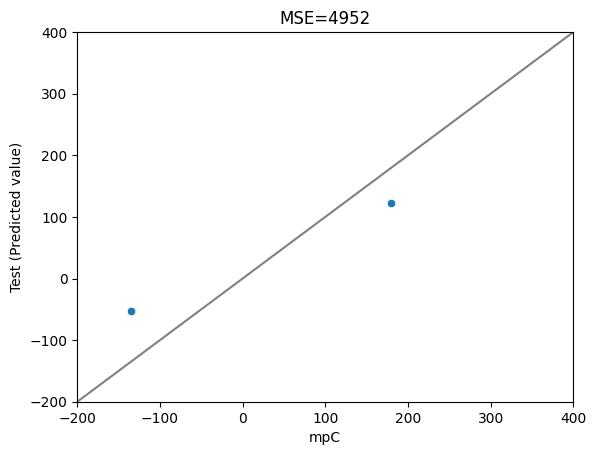

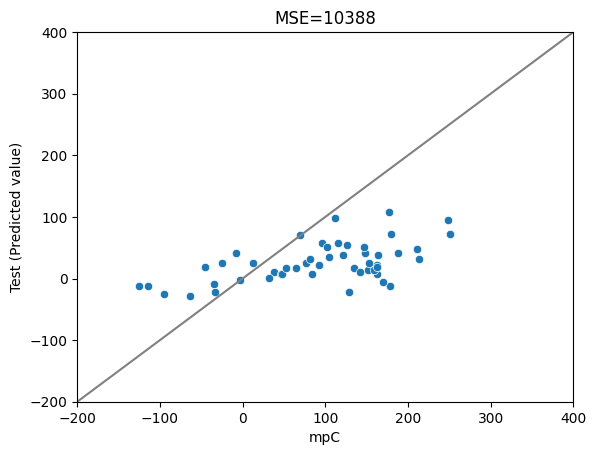

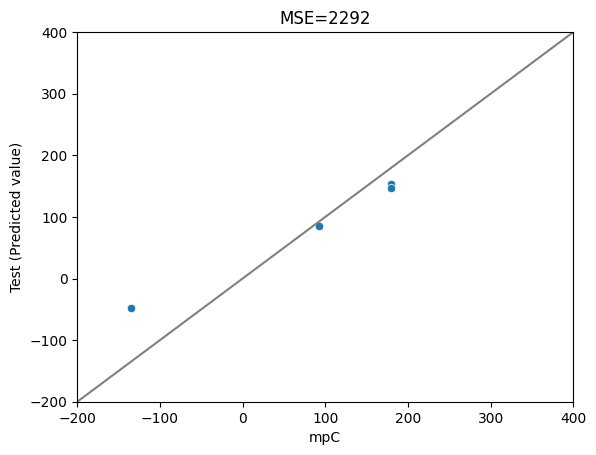

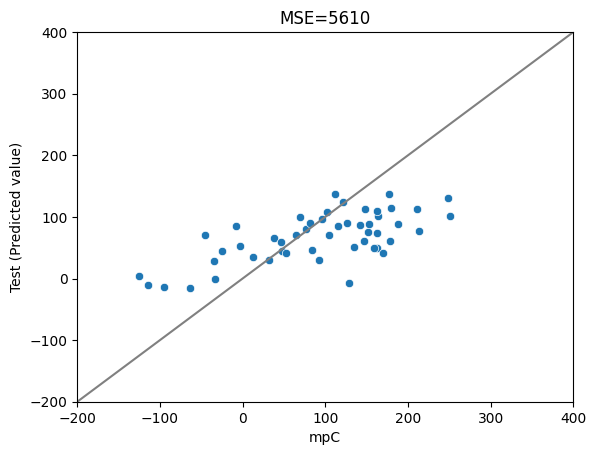

In [15]:
from sklearn.ensemble import RandomForestRegressor


# %%
model_dict = {
    "Random forest": {
        "name": "Random forest",
        "modules": RandomForestRegressor()
    },


}


df = pd.read_csv(dataset_path)

#dummy values
epochs=3
r=32
n_train=0

for n_train in [1,2,3,4,5, 10, 20, 50, 100, 1000, 2000, 5000, 10000]:
    for model_nickname in model_dict:
        model_name = model_dict[model_nickname]["name"]
        model=model_dict[model_nickname]["modules"]

        for with_reason in [False]:
            print("trial----")
            print(f"model {model_name} reason: {with_reason}")
            # project path
            if with_reason:
                project_dir = f"results/projects/240118comparisons/{model_nickname}_{epochs}_{r}_{n_train}"
            else:
                project_dir = f"results/projects/240118comparisons_wo_reason/{model_nickname}_{epochs}_{r}_{n_train}"
            print("Task :", project_dir)


            # make project dir
            make_project_dirs(project_dir)

            # load dataset
            dataset = df.to_dict(orient="records")
            random.seed(0)
            random.shuffle(dataset)

            # prediction without reason
            if not with_reason:
                for data in dataset:
                    data["Reason"] = "-"

            train_dataset = dataset[:n_train]
            test_dataset = dataset[-n_test:]

            random.shuffle(train_dataset)
            # eval
            train_check_dataset = copy.deepcopy(
                train_dataset[:n_train_check])
            random.shuffle(train_check_dataset)

            if len(glob.glob(f"{project_dir}/eval/test*")) > 0:
                print(f"test exists: {project_dir}")
                continue

            tr_X,tr_y=prepare_X_y(train_dataset)
            tr_c_X,tr_c_y=prepare_X_y(train_check_dataset)
            te_X,te_y=prepare_X_y(test_dataset)

            model.fit(tr_X,tr_y)

            train_eval_result = eval_model(model,  train_check_dataset,
                                            f"{project_dir}/eval",
                                            prefix=f"train"
                                            )

            test_eval_result = eval_model(model,  test_dataset,
                                            f"{project_dir}/eval",
                                            prefix=f"test"
                                            )



     

In [16]:
len(train_dataset)

10000